In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## True function and synthetic data
> Defines the true function that the data lies on

> Creates synthetic data based on the true function

In [2]:
def true_func(x):
    # Example function: y = 2*x^2 + x + 2
    return 2 * x**2 + 1.0 * x + 2.0

def create_synthetic_data(num_samples: int, noise_level: float, random_state=42) -> tuple[torch.tensor, torch.tensor]:
    # Set seed for reproducibility
    torch.manual_seed(random_state)
    np.random.seed(random_state)

    # Generate input features (x)
    x_train = torch.linspace(-1, 1, num_samples).unsqueeze(1)

    # Generate the true target values (y_true) without noise
    y_true = true_func(x_train)

    # Add Gaussian noise to simulate real-world data
    print(y_true.size())
    noise = torch.randn(y_true.size()) * noise_level
    y_train = y_true + noise

    return x_train, y_train

## Basic data plotter

In [3]:
def plot_data(x_train: torch.tensor, y_train: torch.tensor, y_true: torch.tensor):
    plt.figure(figsize=(10, 6))
    plt.scatter(x_train.numpy(), y_train.numpy(), label='Synthetic Data (with noise)', alpha=0.7, s=25) # Convert tensors to numpy for plotting
    plt.plot(x_train.numpy(), y_true.numpy(), color='red', linestyle='--', label='True Underlying Function') # Plot the true function
    plt.title('Synthetic Quadratic Data')
    plt.xlabel('Feature (x)')
    plt.ylabel('Target (y)')
    plt.legend()
    plt.grid(True)
    plt.show()

## Polynomial feature generator
> From an integer n and a 1d vector x of features, expands the dimensionality of the data in the form [x, xˆ2, xˆ3, ..., xˆn]

In [5]:
def create_poly_features(x, degree):
    """Generates polynomial features: [x, x^2, ..., x^degree]"""
    features = [x**i for i in range(1, degree + 1)]

    # Concatenate along the feature dimension (dim=1)
    return torch.cat(features, dim=1)

## Plot the model predicted curve

In [6]:
def plot_model(poly_model, x_train, y_train, y_true, poly_degree):
    # --- Plotting the results ---
    poly_model.eval()

    # Create a dense range of x values for smooth plotting
    x_plot = torch.linspace(x_train.min(), x_train.max(), 400).unsqueeze(1)
    # Create polynomial features for the plotting points
    x_plot_poly = create_poly_features(x_plot, poly_degree)

    # Get predictions from the trained polynomial model
    with torch.no_grad():
        predicted_poly = poly_model(x_plot_poly)

    plt.figure(figsize=(10, 6))
    # Plot the original noisy data
    plt.scatter(x_train.numpy(), y_train.numpy(), label='Synthetic Data (with noise)', alpha=0.7, s=25)
    plt.plot(x_plot.numpy(), predicted_poly.numpy(), color='orange', label=f'Model (Deg {poly_degree}) Fit', linewidth=2)
    plt.plot(x_train.numpy(), y_true.numpy(), color='red', linestyle='--', label='True Underlying Function') # Plot the true function

    if poly_degree > 1:
        title = f'Polynomial Regression (Degree {poly_degree}, Overfitting Example)'
    else:
        title = f'Linear Regression (Degree {poly_degree}, Underfitting Example)'
    plt.title(title)
    plt.xlabel('Feature (x)')
    plt.ylabel('Target (y)')
    plt.legend()
    plt.grid(True)
    plt.ylim(min(y_train.numpy()) - 1, max(y_train.numpy()) + 1) # Adjust y-limits to see oscillations
    plt.show()

## Polynomial Regressor class

In [7]:
class PolynomialRegressionModel(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegressionModel, self).__init__()
        # Linear layer takes 'degree' input features, produces 1 output feature
        self.linear = nn.Linear(in_features=degree, out_features=1)

    def forward(self, x_poly):
        # Pass the polynomial features through the linear layer
        return self.linear(x_poly)

    def fit(self, x_train: torch.tensor, y_train: torch.tensor, num_epochs: int = 1000, learning_rate: float = 0.01, alpha=0.0):
        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=alpha)

        for epoch in range(num_epochs):
            self.train()  # Set the model to training mode
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass: compute predicted y
            y_pred = self(x_train)

            # Compute the loss
            loss = criterion(y_pred, y_train)

            # Backward pass: compute gradients
            loss.backward()

            # Update weights
            optimizer.step()

            # Print progress every 100 epochs
            # if (epoch + 1) % 1000 == 0:
                # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

### Constants

In [8]:
NUM_SAMPLES = 50
NOISE_LEVEL = 1
POLY_DEGREE = 10
LEARNING_RATE = 0.001
EPOCHS = 30000
ALPHA = 0.1 # Weight decay for regularization

x_train, y_train = create_synthetic_data(NUM_SAMPLES, NOISE_LEVEL)
y_true = true_func(x_train)

x_poly_train = create_poly_features(x_train, POLY_DEGREE)

torch.Size([50, 1])


## Plotting

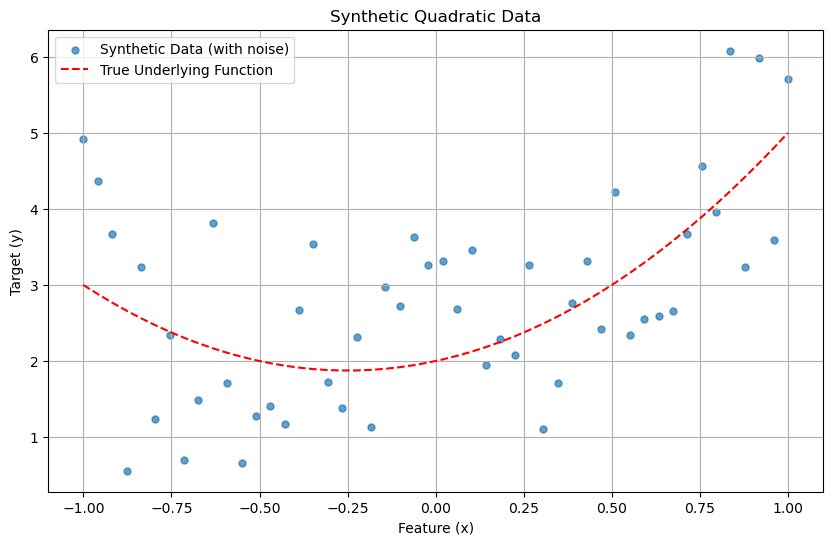

In [9]:
plot_data(x_train, y_train, y_true)

## Linear Model

Epoch [10000/10000], Loss: 1.4257


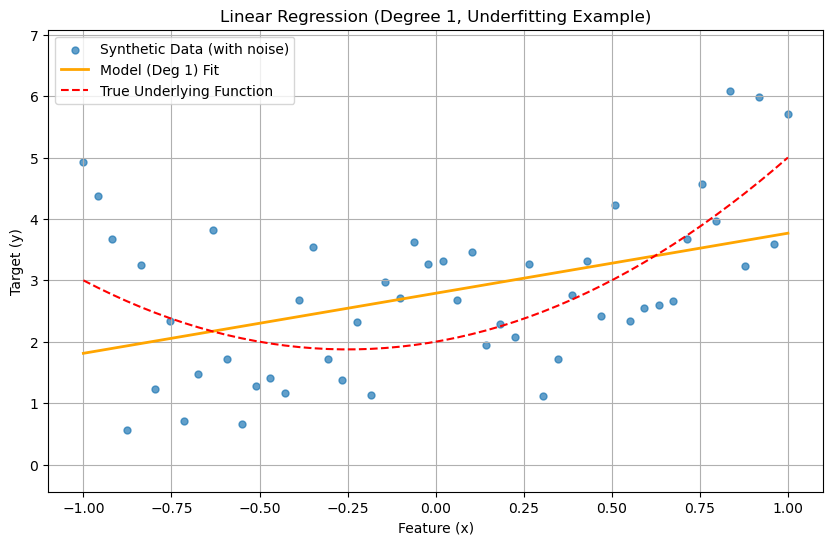

In [10]:
linear_model = PolynomialRegressionModel(degree=1)
linear_model.fit(
    x_train=x_train, 
    y_train=y_train,
    num_epochs=10000, 
    learning_rate=0.001)
plot_model(linear_model, x_train, y_train, y_true, poly_degree=1)

## Polynomial model

Epoch [1000/1000], Loss: 2.4386


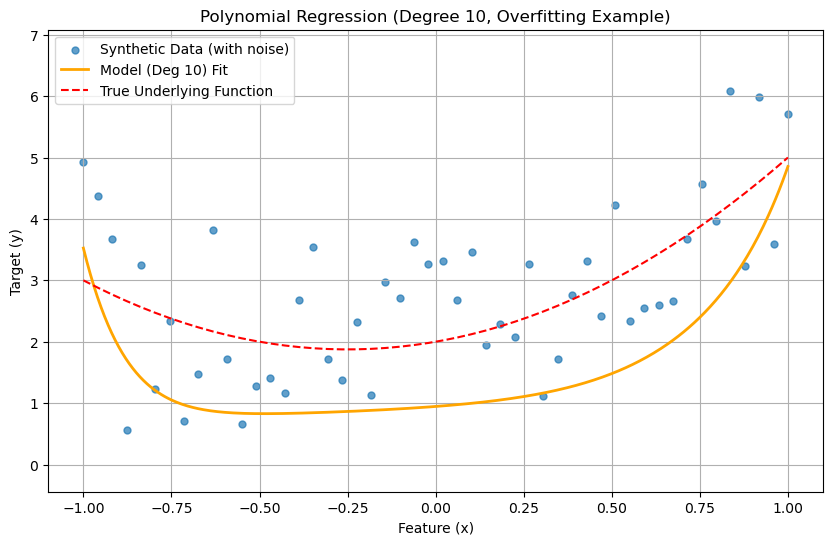

In [11]:
poly_model = PolynomialRegressionModel(degree=10)
poly_model.fit(
    x_train=x_poly_train, 
    y_train=y_train,
    num_epochs=1000, 
    learning_rate=0.001)
plot_model(poly_model, x_train, y_train, y_true, poly_degree=10)

Epoch [30000/30000], Loss: 0.7777


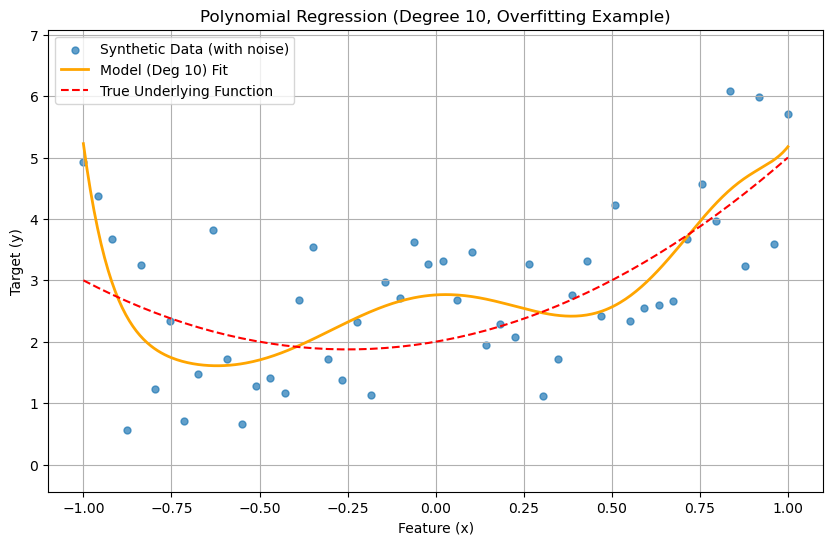

In [12]:
poly_model = PolynomialRegressionModel(degree=POLY_DEGREE)
poly_model.fit(x_train=x_poly_train, 
    y_train=y_train,
    num_epochs=EPOCHS, 
    learning_rate=LEARNING_RATE)
plot_model(poly_model, x_train, y_train, y_true, poly_degree=POLY_DEGREE)

## Polynomial model with weight decay

Epoch [30000/30000], Loss: 0.9211


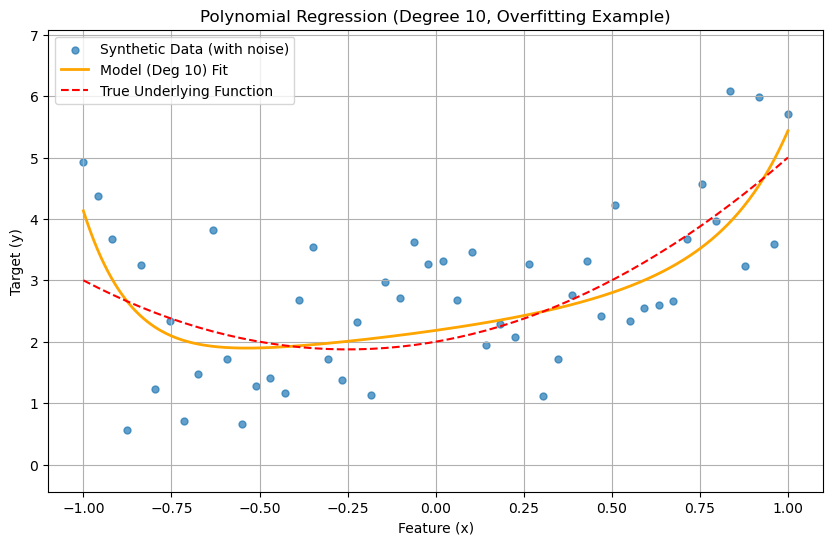

In [13]:
poly_model = PolynomialRegressionModel(degree=POLY_DEGREE)
poly_model.fit(
    x_train=x_poly_train, 
    y_train=y_train,
    num_epochs=EPOCHS, 
    learning_rate=LEARNING_RATE,
    alpha=ALPHA)
plot_model(poly_model, x_train, y_train, y_true, poly_degree=POLY_DEGREE)

## Cool example taken from scikit-learn documentation
> Adapted to include weight decay

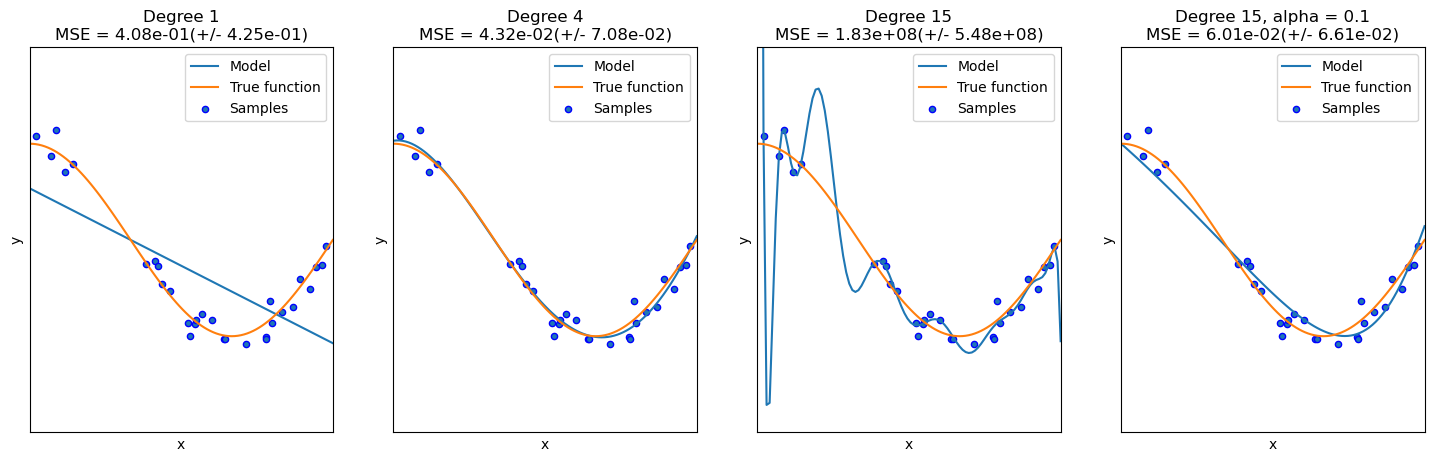

In [14]:

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(18, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    if i == 3:
        linear_regression = Ridge(alpha=.1)

    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")

    if i == 3:
        title = "Degree {}, alpha = 0.1\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    else:
        title = "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    plt.title(
        title
    )


plt.show()